In [148]:
import numpy as np 
import pandas as pd
import glob
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,7)

def extract_mean_max_min(data,start_time,win_size=50): #25Hz sampling rate
    avg=0
    min_mag=1e9
    max_mag=-1e9
    diff_max_min=0
    for i in range(start_time,start_time+win_size):
        if(i>=len(data)):
            break
        mag=(data.loc[i,'Magnitude'])
        avg+=mag
        min_mag=min(min_mag,mag)
        max_mag=max(max_mag,mag)
        diff_max_min=max(diff_max_min,max_mag-min_mag)
    return round(avg/win_size,2),min_mag,max_mag,diff_max_min
    

def detect_free_fall(df,threshold_tending_0,impact_activity,inactivity,win_size=50,overlap_win=25):
    faller=0
    df.reset_index(inplace=True,drop=True)
    for i in range(0,df.index[-1]-2*win_size,overlap_win): 
        if(faller>0):
            faller-=1
            continue
        avg_mag,min_mag,max_mag,diff_max_min=extract_mean_max_min(df,i,win_size)

        if(min_mag<=threshold_tending_0):#fall detected
            print(i,"Free Fall detected")
            #Searching for impact
            if(diff_max_min>=impact_activity):#min max diff
                print(i,"Impact detected , val:",diff_max_min)
                temp_size=5 #window size for calculating average
                no_of_iterations = 30 #considering 2s [10*10==100 -> 25Hz in 1s]
                sum_diff=0
                for j in range(0,no_of_iterations+1):
                    print(extract_mean_max_min(df,i+win_size+ (j*temp_size),temp_size)[3])
                    sum_diff+=extract_mean_max_min(df,i+win_size+ (j*temp_size),temp_size)[3]
                avg_sum_diff = sum_diff/no_of_iterations
                if(avg_sum_diff<=inactivity):
                    print(i,"Inactivness, FALL CONFIRMED", avg_sum_diff)
                    faller=2
                else:
                    print(i,"Inactivness not detected, but value:",avg_sum_diff)   

def detect_free_fall_classifier(df,threshold_tending_0,impact_activity,inactivity,win_size=50,overlap_win=25):
    faller=0
    df.reset_index(inplace=True,drop=True)
    for i in range(0,df.index[-1]-2*win_size,overlap_win): 
        if(faller>0):
            faller-=1
            continue
        avg_mag,min_mag,max_mag,diff_max_min=extract_mean_max_min(df,i,win_size)

        if(min_mag<=threshold_tending_0):#fall detected
            # print(i,"Free Fall detected")
            #Searching for impact
            if(diff_max_min>=impact_activity):#min max diff
                #print(i,"Impact detected , val:",diff_max_min)
                temp_size=5 #window size for calculating average
                no_of_iterations = 30 #considering 2s [10*10==100 -> 25Hz in 1s]
                sum_diff=0
                for j in range(0,no_of_iterations+1):
                    sum_diff+=extract_mean_max_min(df,i+win_size+ (j*temp_size),temp_size)[3]
                    
                avg_sum_diff = sum_diff/no_of_iterations
                if(avg_sum_diff<=inactivity):
                    #print(i,"Inactivness, FALL CONFIRMED")
                    return True,i
                    faller=2
                # else:
                    #print(i,"Inactivness not detected, but value:",avg_sum_diff)
    return False,0

In [48]:
def plot(df,start,end,showx=False,showy=False,showz=False,showTotal=True):
    legend_lst=[]
    if(showx):
        sns.lineplot(y = 'X', x = df.index[start:end], data = df[start:end])
        legend_lst+='X'
    if(showy):
        sns.lineplot(y = 'Y', x = df.index[start:end], data = df[start:end])
        legend_lst+='Y'
    if(showz):
        sns.lineplot(y = 'Z', x = df.index[start:end], data = df[start:end])
        legend_lst+='Z'
    if(showTotal):
        sns.lineplot(y = 'Magnitude', x = df.index[start:end], data = df[start:end])
        legend_lst+='Magnitude'
    plt.legend(legend_lst)
    plt.ylabel("magnitude")
    plt.title("Accelerometer Plot from "+str(start)+" till "+str(end), fontsize = 15)
    plt.show()

In [49]:
df=pd.read_csv("/Users/mohitbagaria/Fall-Detection-using-Accelerometer/tested_datas/CompleteDataSet.csv")
df=df.iloc[2:]

In [50]:
df1 = df[['Subject','Activity','Trial','Tag']]

In [51]:
df1.reset_index(inplace=True,drop=True)
df1

,Subject,Activity,Trial,Tag
0,1.0,1.0,1.0,7.0
1,1.0,1.0,1.0,7.0
2,1.0,1.0,1.0,7.0
3,1.0,1.0,1.0,7.0
4,1.0,1.0,1.0,7.0
...,...,...,...,...
294672,17.0,11.0,3.0,11.0
294673,17.0,11.0,3.0,11.0
294674,17.0,11.0,3.0,11.0
294675,17.0,11.0,3.0,11.0


In [52]:
df2 = df.iloc[:,29:32]
df2.reset_index(inplace=True,drop=True)
df2.columns=['X','Y','Z']
df2['X']=df2['X'].astype(float)
df2['Y']=df2['Y'].astype(float)
df2['Z']=df2['Z'].astype(float)
df2

,X,Y,Z
0,-1.240,-0.557,0.227
1,-1.884,-0.687,0.251
2,-1.884,-0.687,0.251
3,-1.597,-0.646,0.112
4,-1.096,-0.204,0.179
...,...,...,...
294672,0.310,0.545,0.835
294673,0.304,0.549,0.833
294674,0.318,0.555,0.824
294675,0.321,0.561,0.822


In [53]:
df2['Magnitude']=np.sqrt(df2['X']*df2['X']+df2['Y']*df2['Y']+df2['Z']*df2['Z'])
df2

,X,Y,Z,Magnitude
0,-1.240,-0.557,0.227,1.378179
1,-1.884,-0.687,0.251,2.020996
2,-1.884,-0.687,0.251,2.020996
3,-1.597,-0.646,0.112,1.726346
4,-1.096,-0.204,0.179,1.129103
...,...,...,...,...
294672,0.310,0.545,0.835,1.044198
294673,0.304,0.549,0.833,1.042931
294674,0.318,0.555,0.824,1.043132
294675,0.321,0.561,0.822,1.045680


In [54]:
data=pd.concat([df1,df2],axis=1)
data

,Subject,Activity,Trial,Tag,X,Y,Z,Magnitude
0,1.0,1.0,1.0,7.0,-1.240,-0.557,0.227,1.378179
1,1.0,1.0,1.0,7.0,-1.884,-0.687,0.251,2.020996
2,1.0,1.0,1.0,7.0,-1.884,-0.687,0.251,2.020996
3,1.0,1.0,1.0,7.0,-1.597,-0.646,0.112,1.726346
4,1.0,1.0,1.0,7.0,-1.096,-0.204,0.179,1.129103
...,...,...,...,...,...,...,...,...
294672,17.0,11.0,3.0,11.0,0.310,0.545,0.835,1.044198
294673,17.0,11.0,3.0,11.0,0.304,0.549,0.833,1.042931
294674,17.0,11.0,3.0,11.0,0.318,0.555,0.824,1.043132
294675,17.0,11.0,3.0,11.0,0.321,0.561,0.822,1.045680


In [55]:
data['Activity'].value_counts()

6.0     54568
7.0     54032
8.0     53689
11.0    50872
10.0    26694
4.0      9248
3.0      9237
1.0      9203
2.0      9188
5.0      9074
9.0      8872
Name: Activity, dtype: int64

In [56]:
# data.loc[data['Activity']>=6,'Activity']=6

In [57]:
# data['Activity'].value_counts()

In [58]:
activity={  
            1:"Falling forward on hands",
            2:"Falling forward on knees",
            3:"Falling backwards", 
            4:"Falling sidewards",
            5:"Falling from chair",
            6:"walking",
            7:"standing",
            8:"sitting",
            9:"picking up object",
            10:"jumping",
            11:"lying"
         }


In [59]:
data.describe()

,Subject,Activity,Trial,Tag,X,Y,Z,Magnitude
count,294677.000000,294677.000000,294677.000000,294677.000000,294677.000000,294677.000000,294677.000000,294677.000000
mean,8.989731,7.395134,1.994767,8.365627,-0.126846,-0.125564,0.211382,1.070522
std,4.896792,2.592322,0.817695,2.312603,0.769786,0.606931,0.522516,0.405557
min,1.000000,1.000000,1.000000,1.000000,-5.502000,-5.372000,-9.259000,0.013601
25%,5.000000,6.000000,1.000000,7.000000,-0.765000,-0.506000,-0.040000,0.961803
50%,9.000000,7.000000,2.000000,8.000000,-0.189000,-0.210000,0.185000,1.034355
75%,13.000000,10.000000,3.000000,11.000000,0.450000,0.260000,0.608000,1.077288
max,17.000000,11.000000,3.000000,20.000000,7.115000,6.431000,6.139000,9.736940


In [60]:
def one_trial_ac_sub(subid,actid,trialid):
    groups_users= data.groupby('Subject')
    one_subject=groups_users.get_group(subid) #####
    groups_activity= one_subject.groupby('Activity')
    one_activity=groups_activity.get_group(actid) #####
    groups_trials=one_activity.groupby('Trial')
    one_trial_data=groups_trials.get_group(trialid) ####
    one_trial_data.reset_index(inplace=True,drop=True)
    one_trial_data
    print(detect_free_fall(one_trial_data,0.4,2,0.4,30,15))
    plot(one_trial_data,0,one_trial_data.index[-1])

15 Free Fall detected
15 Impact detected , val: 2.728002816565881
1.3912283191026589
0.4634877585881916
0.12514605276976043
0.15719700081833787
0.11799332346453606
0.04948461727131381
0.06179458971929641
0.02557720515192119
0.029156063533400278
0.11707288282459105
0.07349657140016186
0.12677207029729898
0.2170725256986874
0.3441388564837964
0.20774805716504174
0.05637558806946252
0.010752597455611745
0.06153488696614762
0.010042667911053016
0.004550810735745259
0.009316978953964217
0.011137603778207383
0.03085918750058969
0.02681463890900493
0.007879104057107789
0.019429521193285337
0.017834109375926
0
0
0
0
15 Inactivness, FALL CONFIRMED 0.12579645297316996
None


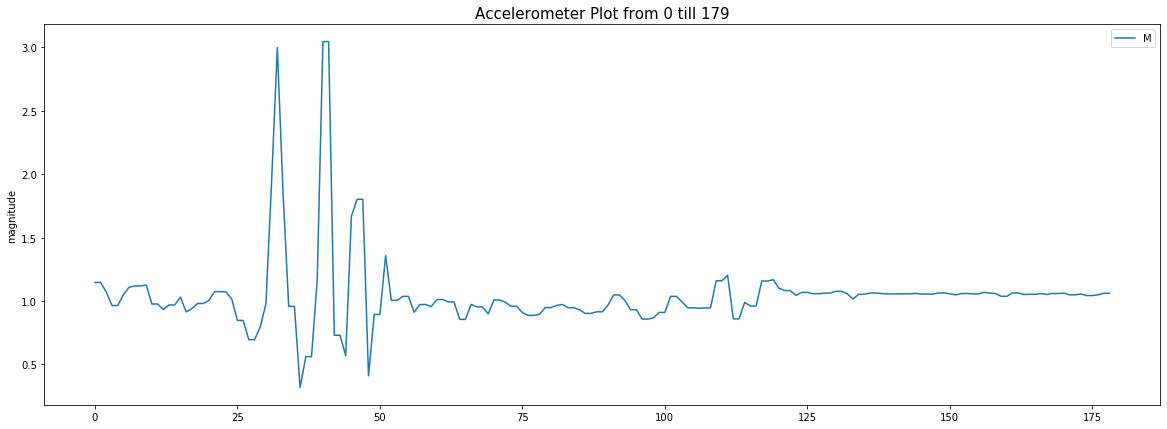

In [61]:
one_trial_ac_sub(17,5,2)

0 Free Fall detected
0 Impact detected , val: 3.614169263609976
3.5428681515689573
0.7038362369046409
2.387740155336828
0.27910799756378013
2.3744083706721293
2.33861080603788
2.7630721159266782
3.2824496912191026
2.667300769482321
2.65097460549599
2.758667626230022
2.9414397214784103
2.8595764025583503
2.2887621694331455
3.036890889192789
3.0074175516801924
3.0450308309403225
3.526882121611815
0.4805889332343279
2.68341510606884
0.2710213233321128
3.069368423221512
3.1899172252173846
2.5010928684191547
2.673407590945946
1.0681315744891369
2.933199842561109
3.1206885655461143
1.8492462211733618
3.337489031957806
2.7821304654717496
0 Inactivness not detected, but value: 2.547157779499064
15 Free Fall detected
15 Impact detected , val: 3.641566637057482
0.27910799756378013
2.3744083706721293
2.33861080603788
2.7630721159266782
3.2824496912191026
2.667300769482321
2.65097460549599
2.758667626230022
2.9414397214784103
2.8595764025583503
2.2887621694331455
3.036890889192789
3.00741755168019

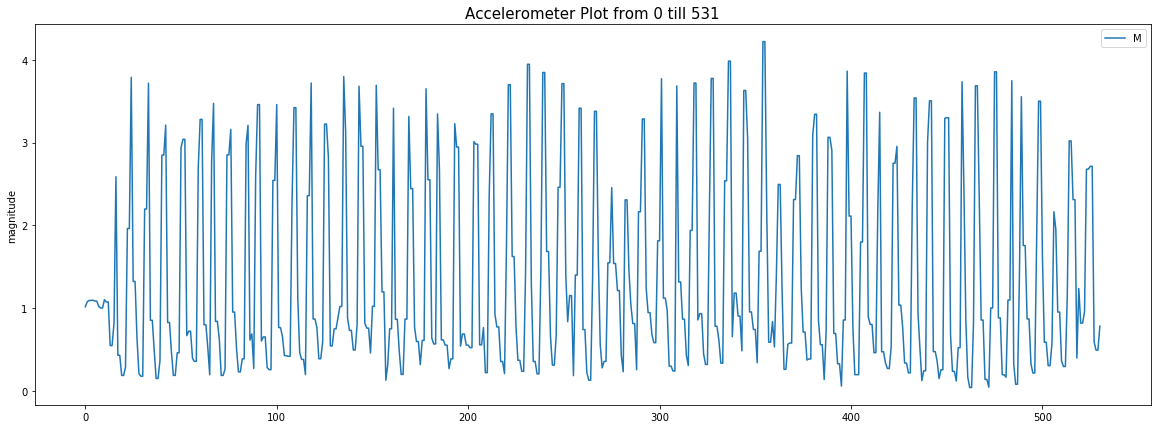

In [62]:
one_trial_ac_sub(17,10,3)

None


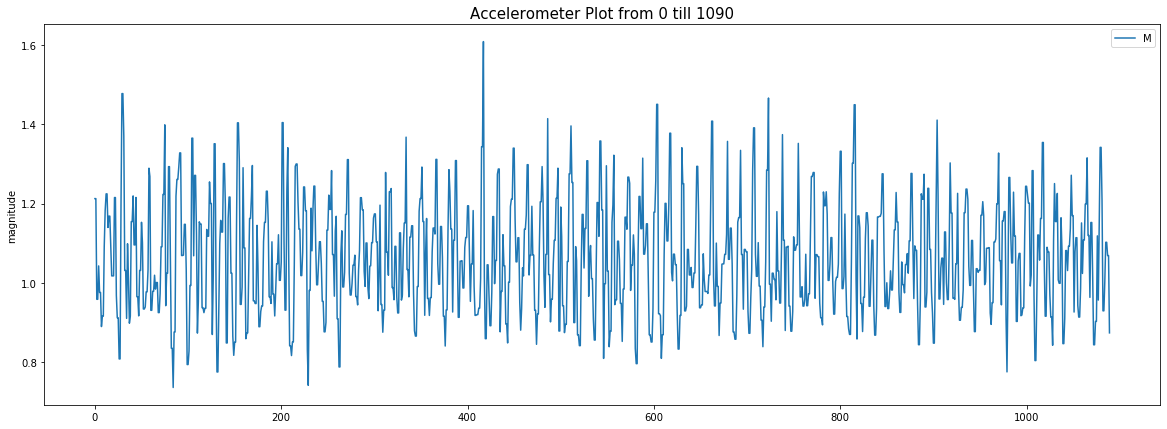

In [63]:
one_trial_ac_sub(17,6,1)

None


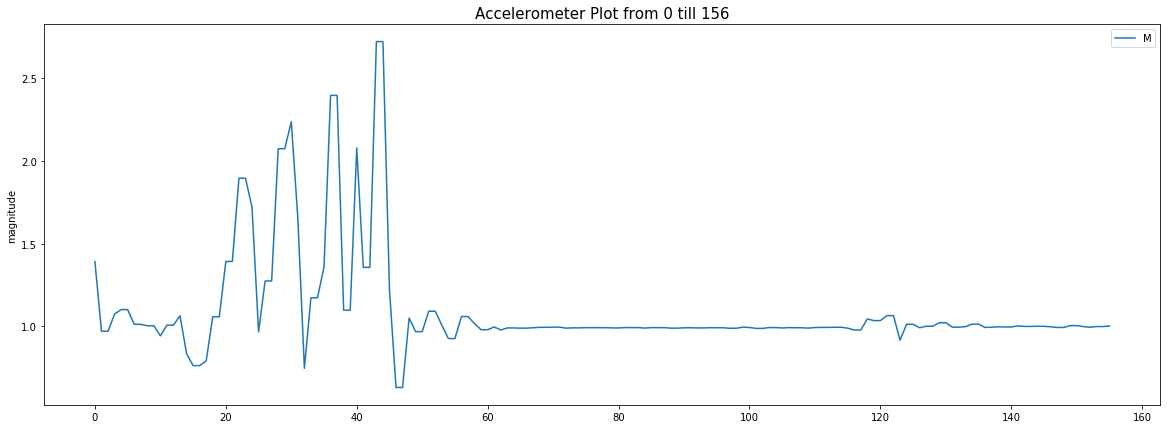

In [82]:
one_trial_ac_sub(1,2,1)

15 Free Fall detected
15 Impact detected , val: 3.036826313540987
0.3461880997263549
0.12190552621728035
0.39275742325352825
0.1729549841340594
0.19453211190287645
1.0397583329891324
1.5238027783501948
0.08310767273254505
0.05380959365128035
0.0424008458411167
0.03129404668785307
0.01362788723233388
0.007428585606670035
0.008169872526401445
0.00322055621542372
0.004086427124608605
0.002444940880523827
0.002055995870044791
0.003093592682454238
0.0017659921784123345
0.004911905591698185
0.0015322828733002058
0.004623663138564327
0.002804504983995093
0.00501379518744538
0.008979913285598995
0.00695408746013193
0.01030251747339972
0.013436930987151596
0.0025758527996464498
0
15 Inactivness, FALL CONFIRMED 0.13698469065280083
None


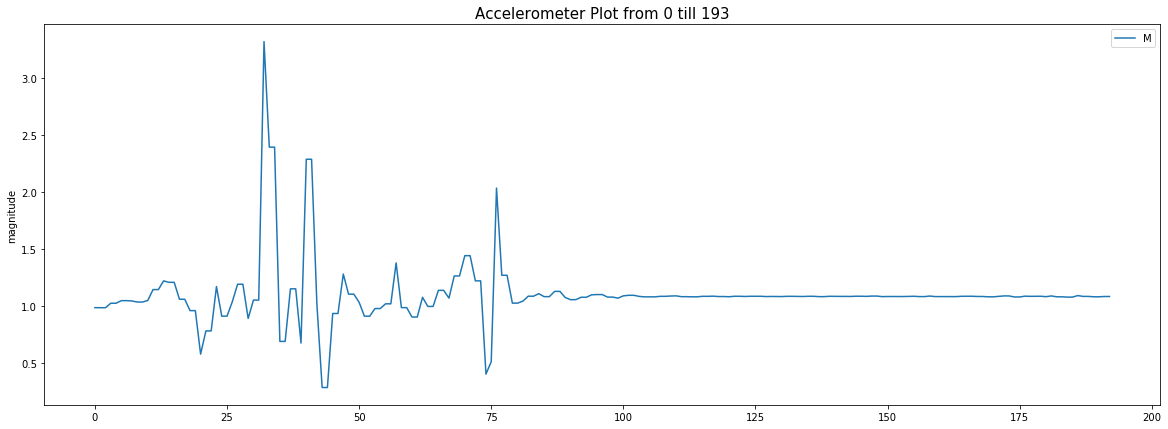

In [84]:
one_trial_ac_sub(1,1,3)

In [64]:
detect_free_fall_classifier(one_trial_data,0.4,2,0.4,200,100)
detect_free_fall(one_trial_data,0.4,2,0.4,25,5)

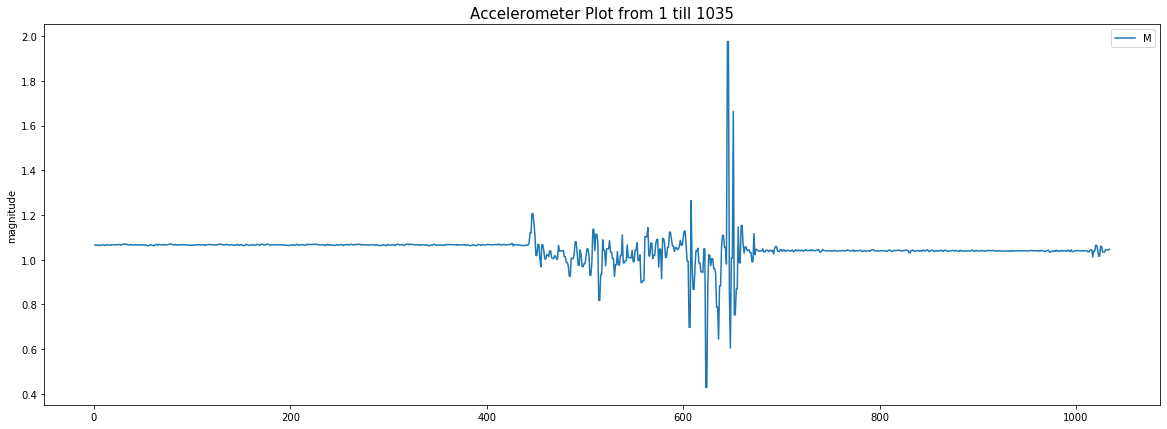

In [65]:
plot(one_trial_data,1,one_trial_data.index[-1])

In [161]:
for activity_no in range(1,12):
        print("Data:", activity[activity_no])

Data: Falling forward on hands
Data: Falling forward on knees
Data: Falling backwards
Data: Falling sidewards
Data: Falling from chair
Data: walking
Data: standing
Data: sitting
Data: picking up object
Data: jumping
Data: lying


In [149]:
groups_users= data.groupby('Subject')
subject_list=[]
activity_list=[]
activity_name=[]
trial_list=[]
fall_list = []
predicted_list=[]
fall_index=[]
for i in range(1,18):
    print("Subject :",i)
    one_subject=groups_users.get_group(i)
    groups_activity= one_subject.groupby('Activity')
    for activity_no in range(1,12):
        print("Data:", activity[activity_no])
        

        one_activity=groups_activity.get_group(activity_no)
        groups_trials=one_activity.groupby('Trial')
        for trial_no in range(1,4):
            print("Trial: ",trial_no)
            try:
                one_trial_data=groups_trials.get_group(trial_no)
                # (0.4,2,0.4,25,5) ---> 66%
                # (one_trial_data,0.4,2,0.4,30,15) ---> 69%
                # (one_trial_data,0.4,2,0.2,30,10) ---> 70%
                is_fall,ind=detect_free_fall_classifier(one_trial_data,0.4,2,0.2,30,15)

                if(is_fall==True):
                    predicted_list.append("Fall")
                    fall_index.append(ind)
                else:
                    predicted_list.append("No Fall")
                    fall_index.append(-1)

                subject_list.append(i)
                activity_list.append(activity_no)
                activity_name.append(activity[activity_no])
                if(activity_no<6):
                    fall_list.append("Fall")
                else:
                    fall_list.append("No Fall")
                trial_list.append(trial_no)
            except: 
                "NOT FOUND"

                


Subject : 1
Data: Falling forward on hands
Trial:  1
Trial:  2
Trial:  3
Data: Falling forward on knees
Trial:  1
Trial:  2
Trial:  3
Data: Falling backwards
Trial:  1
Trial:  2
Trial:  3
Data: Falling sidewards
Trial:  1
Trial:  2
Trial:  3
Data: Falling from chair
Trial:  1
Trial:  2
Trial:  3
Data: walking
Trial:  1
Trial:  2
Trial:  3
Data: standing
Trial:  1
Trial:  2
Trial:  3
Data: sitting
Trial:  1
Trial:  2
Trial:  3
Data: picking up object
Trial:  1
Trial:  2
Trial:  3
Data: jumping
Trial:  1
Trial:  2
Trial:  3
Data: lying
Trial:  1
Trial:  2
Trial:  3
Subject : 2
Data: Falling forward on hands
Trial:  1
Trial:  2
Trial:  3
Data: Falling forward on knees
Trial:  1
Trial:  2
Trial:  3
Data: Falling backwards
Trial:  1
Trial:  2
Trial:  3
Data: Falling sidewards
Trial:  1
Trial:  2
Trial:  3
Data: Falling from chair
Trial:  1
Trial:  2
Trial:  3
Data: walking
Trial:  1
Trial:  2
Trial:  3
Data: standing
Trial:  1
Trial:  2
Trial:  3
Data: sitting
Trial:  1
Trial:  2
Trial:  3


In [135]:
print(len(subject_list))
print(len(activity_list))
print(len(trial_list))
print(len(fall_list))
print(len(predicted_list))


559
559
559
559
559


In [136]:
predicted_list

['Fall',
 'Fall',
 'Fall',
 'No Fall',
 'Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'Fall',
 'Fall',
 'Fall',
 'Fall',
 'No Fall',
 'Fall',
 'No Fall',
 'Fall',
 'Fall',
 'Fall',
 'Fall',
 'Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'Fall',
 'No Fall',
 'Fall',
 'No Fall',
 'Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall',
 'No Fall'

In [150]:
test = pd.DataFrame(zip(subject_list,activity_list,trial_list,activity_name,fall_list,predicted_list,fall_index))
test.columns=['Subject_ID','Activity','Trial_No','Description','Actual','Predicted','fall_index']

In [151]:
# 0.4,2,0.2,30,15
test.to_csv("test1 with 04_2_02_30_15.csv",index=False)

In [143]:
for i in range(1,12):
    tmp_data=test[test['Activity']==i]
    print(activity[i], accuracy_score(tmp_data['Actual'], tmp_data['Predicted']))

Falling forward on hands 0.5098039215686274
Falling forward on knees 0.45098039215686275
Falling backwards 0.43137254901960786
Falling sidewards 0.35294117647058826
Falling from chair 0.17647058823529413
walking 1.0
standing 0.9607843137254902
sitting 1.0
picking up object 0.9411764705882353
jumping 0.9607843137254902
lying 0.9795918367346939


In [89]:
for i in range(1,12):
    tmp_data=test[test['Activity']==i]
    print(activity[i], accuracy_score(tmp_data['Actual'], tmp_data['Predicted']))

Falling forward on hands 0.5098039215686274
Falling forward on knees 0.45098039215686275
Falling backwards 0.43137254901960786
Falling sidewards 0.35294117647058826
Falling from chair 0.19607843137254902
walking 0.9607843137254902
standing 0.9411764705882353
sitting 1.0
picking up object 0.9411764705882353
jumping 0.9215686274509803
lying 0.9795918367346939


In [130]:
for i in range(1,12):
    tmp_data=test[test['Activity']==i]
    print(activity[i], accuracy_score(tmp_data['Actual'], tmp_data['Predicted']))

Falling forward on hands 0.5294117647058824
Falling forward on knees 0.45098039215686275
Falling backwards 0.43137254901960786
Falling sidewards 0.3333333333333333
Falling from chair 0.17647058823529413
walking 1.0
standing 0.9215686274509803
sitting 1.0
picking up object 0.9411764705882353
jumping 0.9607843137254902
lying 0.9795918367346939


In [144]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
cm=confusion_matrix(fall_list, predicted_list)
cm

array([[ 98, 157],
       [  8, 296]])

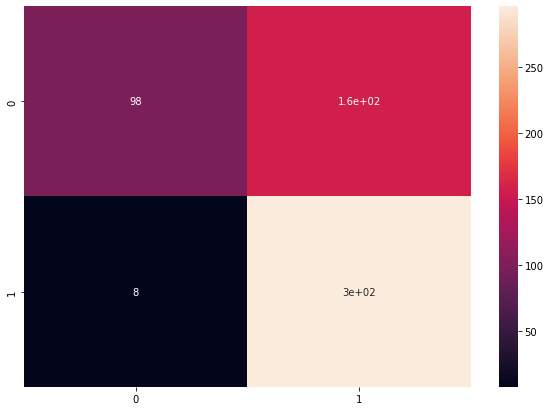

In [145]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)


In [146]:
from sklearn.metrics import accuracy_score
accuracy_score(fall_list, predicted_list)

0.7048300536672629